In [7]:
import nltk
#nltk.download('all')
import spacy
import sys
sys.path.insert(0, "/Users/leon/Income/python files/politeness_code")
from helper.customized_pos import *

### Define customized pos tagger

In [8]:
def pos_postprocessor_pipe(doc) :
    for token in doc :
        if token.text == 'ocbc_plus':
            token.pos_ = 'NOUN'
            token.tag_ = 'NN'
    return doc

In [9]:
nlp = spacy.load('en_core_web_lg')
nlp.add_pipe("pos_postprocessor_pipe", after='tagger')

<function helper.customized_pos.pos_postprocessor_pipe(doc)>

In [22]:
sentence = "So maybe if your friends or relatives or family members are interested you can call back at this number lah this number you can see from your phone lah thank you bye bye \n"

In [23]:
doc = nlp(sentence)

In [24]:
for token in doc:
    print(f'{token.text:{8}} {token.pos_:{6}} {token.tag_:{6}}')

So       ADV    RB    
maybe    ADV    RB    
if       SCONJ  IN    
your     PRON   PRP$  
friends  NOUN   NNS   
or       CCONJ  CC    
relatives NOUN   NNS   
or       CCONJ  CC    
family   NOUN   NN    
members  NOUN   NNS   
are      AUX    VBP   
interested ADJ    JJ    
you      PRON   PRP   
can      AUX    MD    
call     VERB   VB    
back     ADV    RB    
at       ADP    IN    
this     DET    DT    
number   NOUN   NN    
lah      PROPN  NNP   
this     DET    DT    
number   NOUN   NN    
you      PRON   PRP   
can      AUX    MD    
see      VERB   VB    
from     ADP    IN    
your     PRON   PRP$  
phone    NOUN   NN    
lah      PROPN  NNP   
thank    VERB   VBP   
you      PRON   PRP   
bye      INTJ   UH    
bye      INTJ   UH    

        SPACE  _SP   


In [25]:
# Convert spacy pos result to the one accpeted by nltk
pos_ls = []
for token in doc:
    pos_ls.append((token.text, token.tag_))
print(pos_ls)

[('So', 'RB'), ('maybe', 'RB'), ('if', 'IN'), ('your', 'PRP$'), ('friends', 'NNS'), ('or', 'CC'), ('relatives', 'NNS'), ('or', 'CC'), ('family', 'NN'), ('members', 'NNS'), ('are', 'VBP'), ('interested', 'JJ'), ('you', 'PRP'), ('can', 'MD'), ('call', 'VB'), ('back', 'RB'), ('at', 'IN'), ('this', 'DT'), ('number', 'NN'), ('lah', 'NNP'), ('this', 'DT'), ('number', 'NN'), ('you', 'PRP'), ('can', 'MD'), ('see', 'VB'), ('from', 'IN'), ('your', 'PRP$'), ('phone', 'NN'), ('lah', 'NNP'), ('thank', 'VBP'), ('you', 'PRP'), ('bye', 'UH'), ('bye', 'UH'), ('\n', '_SP')]


(S
  (Sentence
    (VP So/RB maybe/RB (PP if/IN (NP your/PRP$ friends/NNS))))
  or/CC
  (Sentence (NP relatives/NNS))
  or/CC
  (Sentence
    (NP family/NN members/NNS)
    (VP are/VBP (NP (JP interested/JJ) you/PRP)))
  (Sentence
    can/MD
    (VP
      call/VB
      back/RB
      (PP
        at/IN
        (NP this/DT number/NN lah/NNP this/DT number/NN you/PRP))))
  (Sentence
    can/MD
    (VP see/VB (PP from/IN (NP your/PRP$ phone/NN lah/NNP)))
    (VP thank/VBP (NP you/PRP)))
  bye/UH
  bye/UH
  
/_SP)


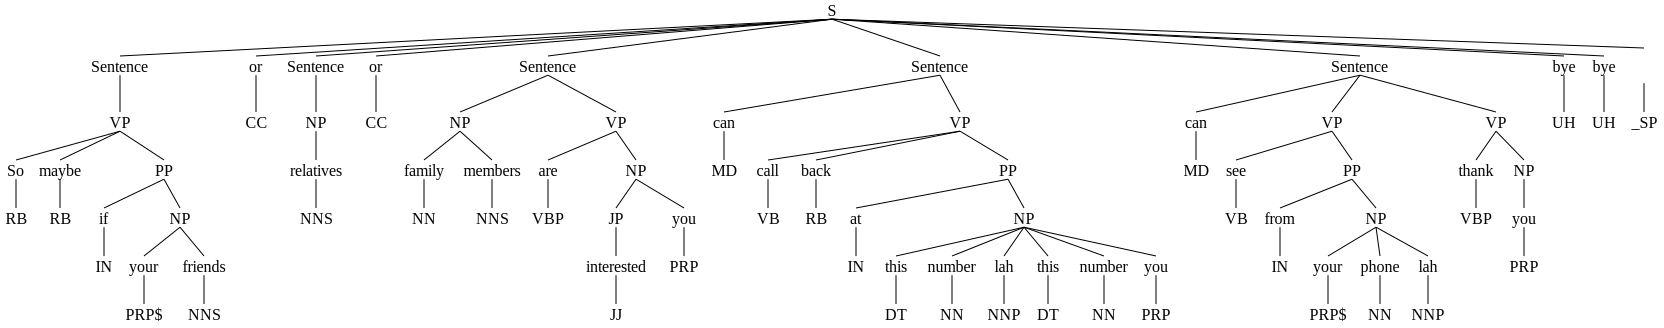

In [40]:
# grammar rules collections

# NP: noun phrases
# PP: preposition phrases
# VP: verb phrases
# 
# grammar = r""" 
#     NP: {<PRP.*|DT|JJ|NN.*>+}
#     PP: {<IN|TO|RP><NP|VB.*>} 
#     VP: {<VB.*|RB.*>+<PP|NP>*}
#     Sentence: {<UH>*<NP>+<MD>*<VP|PP|NP>+}
#     Sentence: {<PP|VP|NP>+}
#     Question: {<MD|WDT|DP|WRB|><MD>*<Sentence|NP|PP|VP>}
    
    
# """
grammars = r""" 
    JP: {<JJ.*>}
    NP: {<JP|CD>*<PRP.*|DT|NN.*>+}
    PP: {<IN|TO|RP><NP|VB.*>} 
    VP: {<VB.*|RB.*>+<PP|NP>*}
    Sentence: {<UH>*<JP|NP>*<MD|IN>*<VP|PP|NP|JP>+}
    Question: {<MD|WDT|DP|WRB|><MD>*<Sentence|NP|PP|VP|JP>}
"""
chunkParser = nltk.RegexpParser(grammars)
chunked = chunkParser.parse(pos_ls)
print(chunked)
chunked

In [27]:
# Loop through the parse tree and extract useful sentences/questions
# This function can only works for Sentence/Question label
def run_traverse(t):
    new_sens = []
    def traverse(t, ls = []):
        try:
            if (t.label() == 'Sentence' or t.label() == "Question") and ls:
                new_sens.append(ls)
                ls = []
        except AttributeError:
            ls.append(t[0])
        else:
            for child in t:
                ls = traverse(child, ls)

        return ls
    ls = traverse(t)
    new_sens.append(ls)
    return new_sens

In [28]:
new_sens = run_traverse(chunked)

In [29]:
new_sens

[['So', 'maybe', 'if', 'your', 'friends', 'or'],
 ['relatives', 'or'],
 ['family', 'members', 'are', 'interested', 'you'],
 ['can',
  'call',
  'back',
  'at',
  'this',
  'number',
  'lah',
  'this',
  'number',
  'you'],
 ['can',
  'see',
  'from',
  'your',
  'phone',
  'lah',
  'thank',
  'you',
  'bye',
  'bye',
  '\n']]

In [36]:
# Try to set up the function can work for any label in the level 1
def run_traverse2(t):
    new_sens = []
    labels = []
    level = 0
    def traverse(t, level = 0, ls = []):
        try:
            if t.label() and level == 1 and ls:
                new_sens.append(ls)
                ls = []
            if t.label() and level == 1:
                labels.append(t.label())
        except AttributeError:
            ls.append(t[0])
        else:
            for i, child in enumerate(t):
                if i == 0:
                    level += 1
                ls = traverse(child, level, ls)
                if i == len(t)-1:
                    level -= 1
        return ls
    ls = traverse(t, level)
    new_sens.append(ls)
    return new_sens, labels

In [37]:
new_sens2 = run_traverse2(chunked)

In [38]:
new_sens2

([['So', 'maybe', 'if', 'your', 'friends'],
  ['relatives'],
  ['family', 'members', 'are', 'interested', 'you'],
  ['can',
   'call',
   'back',
   'at',
   'this',
   'number',
   'lah',
   'this',
   'number',
   'you'],
  ['can', 'see', 'from', 'your', 'phone', 'lah', 'thank', 'you'],
  [],
  [],
  []],
 ['Sentence', 'Sentence', 'Sentence', 'Sentence', 'Sentence'])

In [192]:
# Add label to the return result, e.g. sentence/question
def run_traverse3(t):
    new_sens = []
    labels = []
    level = 0
    def traverse(t, level = 0, ls = []):
        try:
            if t.label() and level == 1 and ls:
                new_sens.append(ls)
                ls = []
            if t.label() and level == 1:
                labels.append(t.label())
        except AttributeError:
            ls.append(t[0])
        else:
            for i, child in enumerate(t):
                if i == 0:
                    level += 1
                ls = traverse(child, level, ls)
                if i == len(t)-1:
                    level -= 1
        return ls
    ls = traverse(t, level)
    new_sens.append(ls)
    return new_sens, labels

In [193]:
new_sens3 = run_traverse3(chunked)

In [194]:
len(new_sens3[1])

5

In [195]:
# Group each label with each sentence as a tuple, and group sentences with less 5 words with the next sentence together
# input example(sentences, labels)
# sen_return_type can be either "list" or "string"
def cluster_part(parts, cluster_threshold = 5, sen_return_type = "string"):
    sen_return_type = sen_return_type.lower()
    if sen_return_type != "string" and sen_return_type != "list":
        raise Exception(f"Current return type {sen_return_type} is not supported.")
    new_sen = []
    temp_sen = []
    # If false, means we won't store current sentence to the temporary list, Otherwise, store the current sentence
    # and insert to the front of the next sentence
    activated = False
    for sentence, label in zip(parts[0], parts[1]):
        if len(sentence) < cluster_threshold and len(temp_sen) < cluster_threshold:
            activated = True
            temp_sen.extend(sentence)
            continue
        else:
            activated = False
            if temp_sen:
                sentence = temp_sen + sentence
                temp_sen = []
            if sen_return_type == "string":
                sentence = " ".join([i for i in sentence])
            new_sen.append((label, sentence))       
    return new_sen
cluster_part(new_sens3, 5, "String")

[('Question', 'may I know how can I help you today ya'),
 ('Sentence', 'hello good afternoon speak to leon'),
 ('Sentence', 'please good afternoon mister leon my name is jimmy and'),
 ('Sentence', 'i m actually calling from income')]

In [196]:
for sentence in doc.sents:
    print(sentence)

ya hello good afternoon speak to nanny seah
please afternoon miss
nally
my name is jaafar same
and im actually calling from income ntuc income miss nally good time to speak for a while
this is regarding our partnership ocbc_plus members and as a result of that income actually formulated a very special fiftieth anniversay insurance bundle right called the i fifty


### Try long sentences

In [197]:
long_sen = "ya hello good afternoon speak to nanny seah please afternoon miss nally my name is jaafar same and im actually calling from income ntuc income miss nally good time to speak for a while this is regarding our partnership ocbc_plus members and as a result of that income actually formulated a very special fiftieth anniversay insurance bundle right called the i fifty "

In [198]:
doc = nlp(long_sen)

In [199]:
# Try sentisizer
for sentence in doc.sents:
    print(sentence)

ya hello good afternoon speak to nanny seah
please afternoon miss
nally
my name is jaafar same
and im actually calling from income ntuc income miss nally good time to speak for a while
this is regarding our partnership ocbc_plus members and as a result of that income actually formulated a very special fiftieth anniversay insurance bundle right called the i fifty


In [200]:
# Try customized grammar rule
pos_ls2 = []
for token in doc:
    pos_ls2.append((token.text, token.tag_))
print(pos_ls2)

[('ya', 'UH'), ('hello', 'UH'), ('good', 'JJ'), ('afternoon', 'NN'), ('speak', 'VBP'), ('to', 'IN'), ('nanny', 'NN'), ('seah', 'NNP'), ('please', 'UH'), ('afternoon', 'NN'), ('miss', 'NNP'), ('nally', 'NNP'), ('my', 'PRP$'), ('name', 'NN'), ('is', 'VBZ'), ('jaafar', 'NNP'), ('same', 'JJ'), ('and', 'CC'), ('i', 'PRP'), ('m', 'VBP'), ('actually', 'RB'), ('calling', 'VBG'), ('from', 'IN'), ('income', 'NN'), ('ntuc', 'NNP'), ('income', 'NNP'), ('miss', 'NNP'), ('nally', 'NNP'), ('good', 'JJ'), ('time', 'NN'), ('to', 'TO'), ('speak', 'VB'), ('for', 'IN'), ('a', 'DT'), ('while', 'NN'), ('this', 'DT'), ('is', 'VBZ'), ('regarding', 'VBG'), ('our', 'PRP$'), ('partnership', 'NN'), ('ocbc_plus', 'NN'), ('members', 'NNS'), ('and', 'CC'), ('as', 'IN'), ('a', 'DT'), ('result', 'NN'), ('of', 'IN'), ('that', 'DT'), ('income', 'NN'), ('actually', 'RB'), ('formulated', 'VBD'), ('a', 'DT'), ('very', 'RB'), ('special', 'JJ'), ('fiftieth', 'JJ'), ('anniversay', 'NN'), ('insurance', 'NN'), ('bundle', 'NN'),

(S
  (Sentence
    ya/UH
    hello/UH
    (NP good/JJ afternoon/NN)
    (VP speak/VBP (PP to/IN (NP nanny/NN seah/NNP))))
  (Sentence
    please/UH
    (NP afternoon/NN miss/NNP nally/NNP my/PRP$ name/NN)
    (VP is/VBZ (NP jaafar/NNP same/JJ)))
  and/CC
  (Sentence
    (NP i/PRP)
    (VP
      m/VBP
      actually/RB
      calling/VBG
      (PP
        from/IN
        (NP
          income/NN
          ntuc/NNP
          income/NNP
          miss/NNP
          nally/NNP
          good/JJ
          time/NN))
      (PP to/TO speak/VB)
      (PP for/IN (NP a/DT while/NN this/DT)))
    (VP
      is/VBZ
      regarding/VBG
      (NP our/PRP$ partnership/NN ocbc_plus/NN members/NNS)))
  and/CC
  (Sentence
    (PP as/IN (NP a/DT result/NN))
    (PP of/IN (NP that/DT income/NN))
    (VP actually/RB formulated/VBD (NP a/DT))
    (VP
      very/RB
      (NP
        special/JJ
        fiftieth/JJ
        anniversay/NN
        insurance/NN
        bundle/NN))
    (VP right/RB called/VBD (NP the/DT

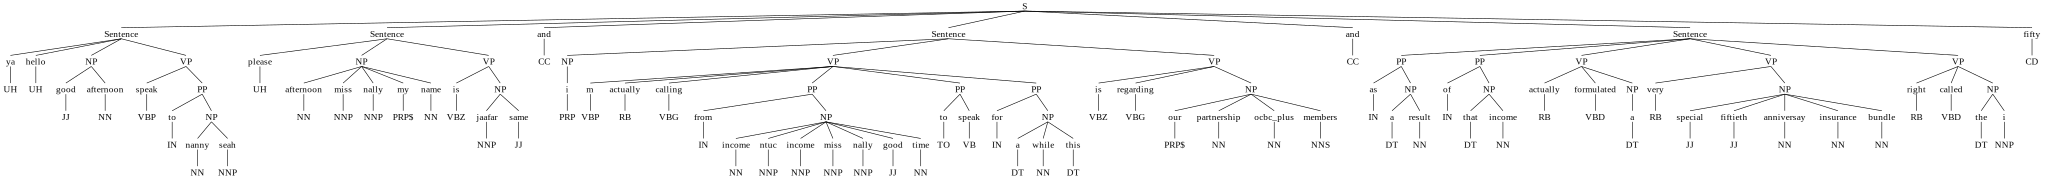

In [201]:
chunkParser = nltk.RegexpParser(grammar)
chunked = chunkParser.parse(pos_ls2)
print(chunked)
chunked

In [202]:
new_sens4 = run_traverse3(chunked)
cluster_part(new_sens4, 5, "String")

[('Sentence', 'ya hello good afternoon speak to nanny seah'),
 ('Sentence', 'please afternoon miss nally my name is jaafar same and'),
 ('Sentence',
  'i m actually calling from income ntuc income miss nally good time to speak for a while this is regarding our partnership ocbc_plus members and'),
 ('Sentence',
  'as a result of that income actually formulated a very special fiftieth anniversay insurance bundle right called the i fifty')]